# TO-DO:
- update training loop (should have 23 passes, I think)

No: As specified in sec. III B., "Several versions of LeNet-5 were trained on the regular MNIST database.  20 iterations through the entire training data were performed for each session. The values of the global learning rate was decreased using the following schedule:
- 0.0005 for the first 2 passes
- 0.0002 for the next 3
- 0.0001 for the next 3
- 0.00005 for the next 4
- 0.00001 thereafter (8)
before each iteration, the diagonal Hessian approximation was reevaluated on 500 samples"
NOTE: "our update algorithm is dubbed the Stochastic Diagonal Levenberg-Marquardt (SDL) method where an individual learning rate is computed for each parameter before each pass through the training set. These learning rates are computed using the diagonal termso f an estimate of the Guss-Newton approximation to the Hessian (2nd derivative) matrix.  This algorithm is not believed to bring a tremendous increase in learning speed, but it converges reliably without extensive adjustments of the learning parrameters. It corrects major ill-conditioning of the loss function that are due to the peculiarities of the network architecture and the training data. The additional cost of using this prcedure over standard SGD is negligible. at each learning iteration, a parameter w_k is updated according to:

$$w_k \leftarrow w_k - \epsilon_k \frac{\partial E^p}{\partial w_k},$$

where $E^p$ is the instantaneous loss function for pattern $p$."

Note: read this section carefully. Additional details for Conv layers etc. You can consider simplifying from this (read sec. III B., they talk about an effective learning rate)

- MNIST is not really the right dataset for this. Might need to scale down fromn 28x28 to 16x16 (e.g. bilinear interpolation). Also think about what to do about the bitmaps in this regard

Think about this more closely, including how you deal with the prototypes!

- make sure to take care of the weight initialization. NOTE: paper seems to have some typos here (says 2.4/F, but should be 2.4/sqrt(F), where F in fan-in)

"Before training, the weights are initialized with random values, using a uniform distribution between -2.4/F_i and 2.4/F_i, where F_i is the number of inputs (fan-in) of the unit which the connectino belongs to."

They further explain:

"The std of the weighted sum scales like the sqrt of F_i when the inputs are independet, and it scales linearly if the inputs are highly correlated. We chose to assume the second hypothesis since some units recieve highly correlated signals."

In [13]:
import os
os.chdir("..")
os.getcwd()

'/Users/mariusmahiout/Documents/repos'

In [4]:
from src.model import LeNet5
from src.fixed_params import get_c3_connectivity
import src.data_proc as data_proc

In [5]:
# modelling
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# data processing
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# plotting
import matplotlib.pyplot as plt

# Loading data

In [6]:
train_data, test_data = data_proc.get_datasets()

In [12]:
img_tensor, label = train_data[0]
img_tensor.shape

torch.Size([1, 32, 32])

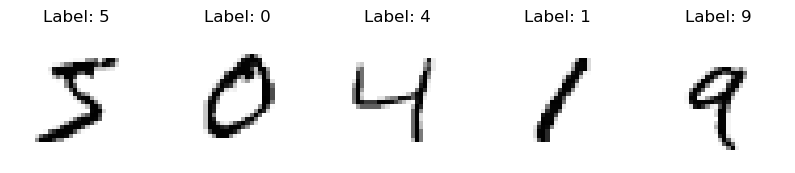

In [7]:
# Visualizing some training examples
num_examples = 5
fig, ax = plt.subplots(ncols=num_examples, figsize=(10,5))
for idx in range(num_examples):
    img_tensor, label = train_data[idx]
    ax[idx].imshow(img_tensor.detach().squeeze(), cmap='Greys')  # default colormap
    ax[idx].set_title(f"Label: {label}")
    ax[idx].axis('off')
plt.show()

In [8]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [9]:
c3_connectivity = get_c3_connectivity()
c3_connectivity = c3_connectivity.t()

# visualizing the connectivity of C3
# See Table I in LeCun et al. 1998
import pandas as pd
df = pd.DataFrame(c3_connectivity, dtype=int)
def red_if_one(val):
    return 'color: red' if val == 1 else ''

colored_df = df.style.applymap(red_if_one)
display(colored_df)

c3_connectivity = c3_connectivity.t().float()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1
1,1,1,0,0,0,1,1,1,0,0,1,1,1,1,0,1
2,1,1,1,0,0,0,1,1,1,0,0,1,0,1,1,1
3,0,1,1,1,0,0,1,1,1,1,0,0,1,0,1,1
4,0,0,1,1,1,0,0,1,1,1,1,0,1,1,0,1
5,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1


In [10]:
model = LeNet5()

In [11]:
############################
# --- LeNet parameters --- #
############################

def get_layer_nparams(layer):
    return sum([p.nelement() for p in layer.parameters()])

#model = LeNet5()

c1_num_params = get_layer_nparams(model.conv1)
s2_num_params = get_layer_nparams(model.subs2)
c3_num_params = get_layer_nparams(model.conv3)
s4_num_params = get_layer_nparams(model.subs4)
c5_num_params = get_layer_nparams(model.conv5)
f6_num_params = get_layer_nparams(model.fc6)
rbf_num_params = get_layer_nparams(model.rbf)

print(f"{c1_num_params=}") # C1 has 156 trainable parameters, and 122,304 connections
print(f"{s2_num_params=}") # S2 has 12 trainable parameters, and 5,880 connections
print(f"{c3_num_params=}") # C3 has 1,515 trainable parameters, and 151,600 connections
print(f"{s4_num_params=}") # S4 has 32 trainable parameters and 2,000 connections
print(f"{c5_num_params=}") # C5 has 48,120 trainable parameters (connections)
print(f"{f6_num_params=}") # F6 has 10,164 trainable parameters
print(f"{rbf_num_params=}") # 0

# The discrepancy in C3 occurs due to using masking to disable 900 of them:
in_ch, out_ch = c3_connectivity.shape[1], c3_connectivity.shape[0]
kernel_size = 5

# Number of active params:
num_connections = int(c3_connectivity.sum().item()) # c3_connectivity consists of 1s and 0s (disabled)
num_weights = num_connections * (kernel_size**2)  # each connection has a 5×5 kernel
num_biases  = out_ch  # one bias per output mapping
num_params  = num_weights + num_biases
print("\nC3 # active params:", num_params)  # 1516


print("---\n")

x = torch.randn(1, 1, 32, 32)  # dummy batch of size 1
print("in:", x.shape)
x = model.conv1(x);         print("after conv1:", x.shape)
x = model.subs2(x);         print("after subs2:", x.shape)
x = model.conv3(x);         print("after conv3:", x.shape)
x = model.subs4(x);         print("after subs4:", x.shape)
x = model.conv5(x);         print("after conv5:", x.shape)
x = x.view(x.size(0), -1);  print("after flatten:", x.shape)
x = model.fc6(x);           print("after fc6:",   x.shape)
x = model.rbf(x);           print("after rbf:",   x.shape)


c1_num_params=156
s2_num_params=12
c3_num_params=2416
s4_num_params=32
c5_num_params=48120
f6_num_params=10164
rbf_num_params=0

C3 # active params: 1516
---

in: torch.Size([1, 1, 32, 32])
after conv1: torch.Size([1, 6, 28, 28])
after subs2: torch.Size([1, 6, 14, 14])
after conv3: torch.Size([1, 16, 10, 10])
after subs4: torch.Size([1, 16, 5, 5])
after conv5: torch.Size([1, 120, 1, 1])
after flatten: torch.Size([1, 120])
after fc6: torch.Size([1, 84])
after rbf: torch.Size([1, 10])


In [22]:
# later:
# lr1 = 5e-4
# lr2 = 1e-4
# lr3 = 2e-5
# lr4 = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=7e-6)
criterion = nn.CrossEntropyLoss()

# loss on test set before training
model.eval()
init_loss = 0.0
with torch.no_grad():
    for imgs, labels in test_loader:
        logits = model(imgs)
        init_loss += criterion(logits, labels).item() * labels.size(0)
init_loss /= len(test_loader.dataset)
print(f"Initial test loss: {init_loss:.4f}")

num_batches = len(train_loader)
model.train()
for batch_idx, (imgs, labels) in enumerate(train_loader):
    optimizer.zero_grad()
    logits = model(imgs)
    loss   = criterion(logits, labels)

    print_every = max(1, num_batches // 10)
    if (batch_idx + 1) % print_every == 0:
        print(f"[Batch {batch_idx+1}/{num_batches}]  Loss: {loss.item():.4f}")

    loss.backward()
    optimizer.step()

Initial test loss: 0.0863
[Batch 187/1875]  Loss: 0.1162
[Batch 374/1875]  Loss: 0.0096
[Batch 561/1875]  Loss: 0.0386
[Batch 748/1875]  Loss: 0.0412
[Batch 935/1875]  Loss: 0.0854
[Batch 1122/1875]  Loss: 0.0103
[Batch 1309/1875]  Loss: 0.0639
[Batch 1496/1875]  Loss: 0.1055
[Batch 1683/1875]  Loss: 0.0196
[Batch 1870/1875]  Loss: 0.0503


In [23]:
model.eval()
test_loss = 0.0
correct   = 0
total     = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        logits = model(imgs)
        test_loss += criterion(logits, labels).item() * labels.size(0)
        preds = logits.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_loss /= len(test_loader.dataset)
acc = 100 * correct / total
print(f"Final test loss: {test_loss:.4f}  |  Accuracy: {acc:.2f}%")


Final test loss: 0.0824  |  Accuracy: 97.55%


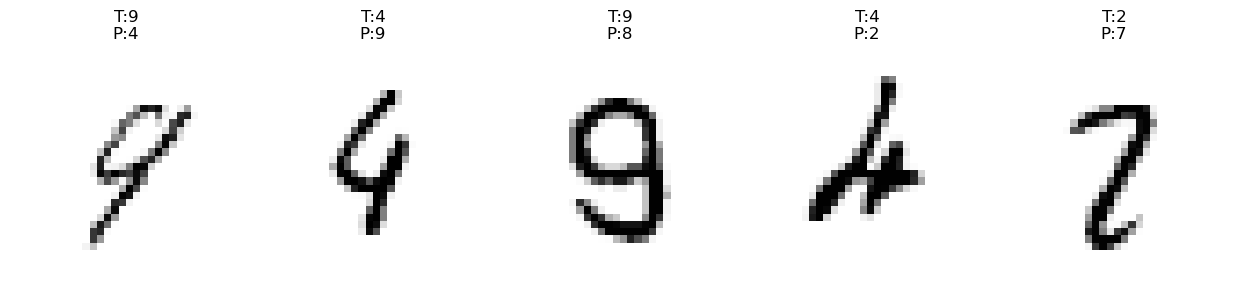

In [24]:
model.eval()
mis_cls = []  # will hold tuples (img, true, pred)

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        mask = preds != labels
        for img, t, p in zip(images[mask], labels[mask], preds[mask]):
            mis_cls.append((img, t.item(), p.item()))
        if len(mis_cls) >= 5:
            break

# Plot the first 5 misclassifications
fig, axes = plt.subplots(1, 5, figsize=(5*2.5, 3))
for i in range(5):
    img, true, pred = mis_cls[i]
    axes[i].imshow(img.squeeze().cpu().numpy(), cmap='Greys')
    axes[i].set_title(f"T:{true}\nP:{pred}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
